In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

In [2]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [3]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def train_test_split_ts_2d_raw(X, h):
    return(X[:-h],X[-h:])


def train_test_split_ts(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

In [4]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size)]
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

In [5]:
def forecast(first_item, model, h, n_step):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        y = model.predict(np.reshape(x,(1,n_step)))
        result.append(y)
        x = np.append(x[1:],np.array(y))
    return(np.array(result))   

In [6]:
def build_model(n_steps, n_units, learning_rate, optimizer_name):
    model = keras.Sequential()
    if len(n_units) == 1:
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
    else:  
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
        for i in range(1,len(n_units)):
            model.add(layers.Dense(n_units[i], activation=tf.nn.relu))
    
    model.add(layers.Dense(1))
    
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [7]:
def cv_hparam_tunning(x, n_steps, num_units, optimizer, learning_rate,
                      training_window=15, forecast_window=1, freq=12,epochs=1):

    fuzzify(x)
    L = len(x)
    errors = []
    
    for i in range(0, L - (training_window+forecast_window)*freq, freq):   

        raw_seq = x[i:i+(training_window + forecast_window)*freq]

        X, y_test = train_test_split_ts_2d_raw(raw_seq, forecast_window*freq) 
        X_train, y_train = split_sequence(X, n_steps)

        #estimator = KerasRegressor(build_fn=baseline_ model(n_steps), epochs=100, batch_size=5, verbose=0)
        model = build_model(n_steps, num_units, learning_rate, optimizer)


        #EPOCHS = 100
        model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

        y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, freq, n_steps)
        y_hat = np.reshape(y_hat,len(y_test))
        if np.any(np.isnan(y_hat)):
            errors.append(np.nan)
        else:
            errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

        #errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))
        
    return(np.nanmean(errors))

In [8]:
def uni_deseasonalize(ts,freq=12):
    ts = np.array(ts)
    avgs = np.zeros(freq)
    stds = np.zeros(freq)
    N = len(ts)
    #averages = np.zeros((freq,n))
    temp = ts
    result = np.zeros((N))
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        avgs[j] = temp[Idx].mean()
        stds[j] = temp[Idx].std()
        result[Idx] = (temp[Idx] - temp[Idx].mean())#/temp[Idx].std()
    return(result, avgs) 

In [11]:
data = np.load('../data.npy')
lat = np.load('../lat.npy')
lon = np.load('../lon.npy')

In [66]:
x = data[27,6,]

In [67]:
n = 30
# Set forecasting window length (in years)
m = 3
# Set annual sampling rate
f = 12 
L = len(x)
errors = []
j = 0


start = 1946
origin = 1960
# Set annual sampling rate
freq = 12
h = m*f
n_steps = 20

index = (origin - start) * f

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [14]:
x_train = x[train_start:train_end]
x_test = x[test_start:test_end]

In [21]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

In [22]:
co2_model = build_model(x_train)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=co2_model)



NameError: name 'sts' is not defined

In [15]:
trend = tfp.sts.LocalLinearTrend(observed_time_series=x_train)
seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=x_train)
model = tfp.sts.Sum([trend, seasonal], observed_time_series=x_train)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [19]:
model

[Parameter(name='observation_noise_scale', prior=<tfp.distributions.LogNormal 'Sum_LogNormal' batch_shape=[] event_shape=[] dtype=float32>, bijector=<tensorflow_probability.python.bijectors.chain.Chain object at 0x7feeaff6b198>),
 Parameter(name='LocalLinearTrend/_level_scale', prior=<tfp.distributions.LogNormal 'LocalLinearTrend_level_scale_prior' batch_shape=[] event_shape=[] dtype=float32>, bijector=<tensorflow_probability.python.bijectors.chain.Chain object at 0x7feeb13d9be0>),
 Parameter(name='LocalLinearTrend/_slope_scale', prior=<tfp.distributions.LogNormal 'LocalLinearTrend_slope_scale_prior' batch_shape=[] event_shape=[] dtype=float32>, bijector=<tensorflow_probability.python.bijectors.chain.Chain object at 0x7feeb13d9be0>),
 Parameter(name='Seasonal/_drift_scale', prior=<tfp.distributions.LogNormal 'Seasonal_LogNormal' batch_shape=[] event_shape=[] dtype=float32>, bijector=<tensorflow_probability.python.bijectors.chain.Chain object at 0x7feeaff759b0>)]

In [36]:
df_clusters = pd.read_csv("clusters.csv")

In [42]:
df_clusters = df_clusters.iloc[:,2:]

In [78]:
data = np.load('../data.npy')
lat = np.load('../lat.npy')
lon = np.load('../lon.npy')

In [79]:
x = data[27,6,]

In [55]:
x = df_clusters.iloc[:,0].values

In [80]:
n = 30
# Set forecasting window length (in years)
m = 3
# Set annual sampling rate
f = 12 
L = len(x)
errors = []
j = 0


start = 1946
origin = 1960
# Set annual sampling rate
freq = 12
h = m*f
n_steps = 20

index = (origin - start) * f

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [58]:
raw_seq = x[index:index+(n+m)*f]
X, y = split_sequence(raw_seq, n_steps)

In [59]:
x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [81]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
X, avgs = uni_deseasonalize(X)

In [82]:
X_train, y_train = split_sequence(X, n_steps)

In [83]:
n_units = [200,100,50,30,20,15,10]
learning_rate = 0.001
optimizer = 'sgd'
epochs = 100

In [105]:
X_train[-1][1:].shape

(19,)

In [84]:
model = build_model(n_steps, n_units, learning_rate, optimizer)
model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [85]:
avgs = np.tile(avgs, int(len(y_hat)/f))
#stds = np.tile(stds, int(len(y_hat)/f))

In [88]:
y_hat = y_hat + avgs

In [94]:
y_hat[y_hat < 0] = 0

In [95]:
math.sqrt(mean_squared_error(y_test,y_hat))

10.3482823653642

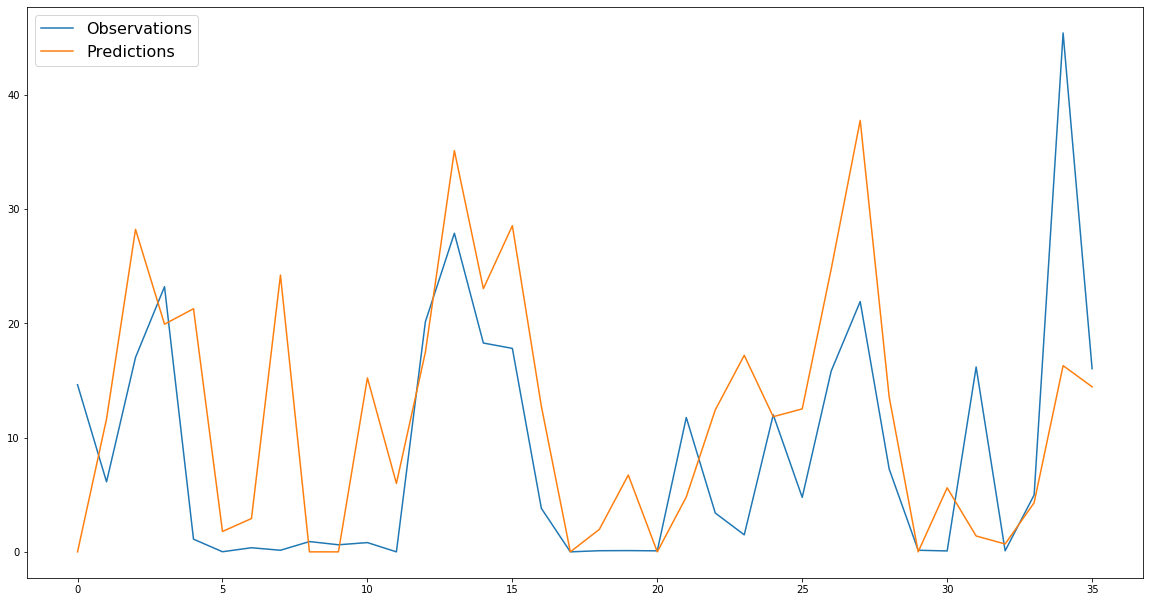

In [96]:
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend(fontsize = 16)

In [ ]:
n = 26
# Set forecasting window length (in years)
m = 13
# Set annual sampling rate
f = 12 
L = x.shape[0]
errors = []
j = 0


start = 1977
origin = 1977
# Set annual sampling rate
freq = 12
h = m*f
n_steps = 12

index = (origin - start) * f

raw_seq = x[index:index+(n+m)*f]
X, y = split_sequence(raw_seq, n_steps)

oni_seq = oni[index:index+(n+m)*f]
X_oni, _ = split_sequence(oni_seq, n_steps)

X = np.hstack((X_oni,X))

X_norm = (X - X.mean(0))/X.std(0)

x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [60]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = X_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 0.9175 - RootMeanSquaredError: 0.9521
mis_rmse 0.9521167874336243
--- Starting trial: run-1
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.0148 - RootMeanSquaredError: 1.0021
--- Starting trial: run-2
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
36/36 [==============================] - 0s 2ms/sample - loss: 0.9912 - RootMeanSquaredError: 0.9909
--- Starting trial: run-3
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.0145 - RootMeanSquaredError: 1.0026
--- Starting trial: run-4
{'num_units 1': 4, 'num_units 2': 4, '

36/36 [==============================] - 0s 2ms/sample - loss: 1.1435 - RootMeanSquaredError: 1.0632
--- Starting trial: run-36
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.0424 - RootMeanSquaredError: 1.0109
--- Starting trial: run-37
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.1097 - RootMeanSquaredError: 1.0442
--- Starting trial: run-38
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.0108 - RootMeanSquaredError: 0.9960
--- Starting trial: run-39
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 1.4069 - RootMeanSquaredE

36/36 [==============================] - 0s 2ms/sample - loss: 0.9530 - RootMeanSquaredError: 0.9627


In [63]:
list(best_hparams.values())

[4, 8, 0.1, 0.001, 'RMSprop']

36/36 [==============================] - 0s 2ms/sample - loss: 1.6679 - RootMeanSquaredError: 1.2630


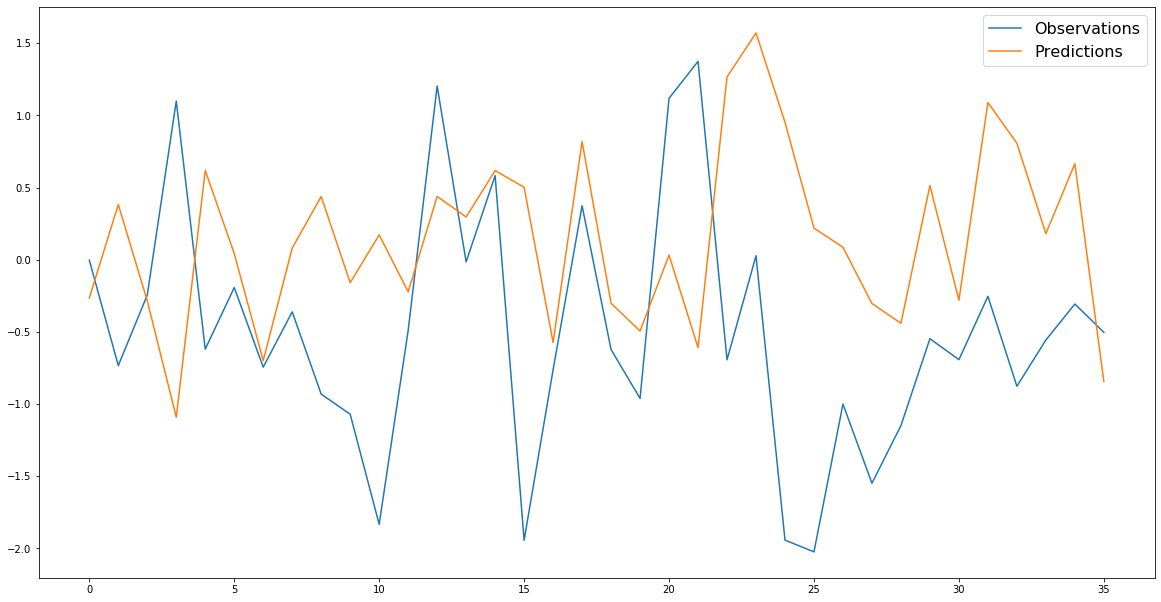

In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(25, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

model.compile(optimizer="RMSProp",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

predictions = model.predict(x_test)

fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend(fontsize = 16)

In [ ]:
if np.any(np.isnan(y_hat)):
    errors.append(np.nan)
else:
    errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

In [255]:
#df_clusters = pd.read_csv("clusters.csv")
df_clusters = pd.read_csv("cluser_pca.csv")
df_clusters = df_clusters.iloc[:,2:]

In [256]:
data = np.load('../data.npy')
lat = np.load('../lat.npy')
lon = np.load('../lon.npy')

In [226]:
lat

array([ 38.75,  36.25,  33.75,  31.25,  28.75,  26.25,  23.75,  21.25,
        18.75,  16.25,  13.75,  11.25,   8.75,   6.25,   3.75,   1.25,
        -1.25,  -3.75,  -6.25,  -8.75, -11.25, -13.75, -16.25, -18.75,
       -21.25, -23.75, -26.25, -28.75, -31.25, -33.75, -36.25, -38.75],
      dtype=float32)

In [227]:
lon

array([336.25, 338.75, 341.25, 343.75, 346.25, 348.75, 351.25, 353.75,
       356.25, 358.75,   1.25,   3.75,   6.25,   8.75,  11.25,  13.75,
        16.25,  18.75,  21.25,  23.75,  26.25,  28.75,  31.25,  33.75,
        36.25,  38.75,  41.25,  43.75,  46.25,  48.75,  51.25,  53.75,
        56.25,  58.75], dtype=float32)

In [257]:
x = data[27,6,]

In [258]:
oni = df_clusters.iloc[:,0].values

In [250]:
n=30
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1960
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [259]:
raw_seq = x[index:index+(n+m)*f]
X, y = split_sequence(raw_seq, n_steps)

oni_seq = oni[index:index+(n+m)*f]
X_oni, _ = split_sequence(oni_seq, n_steps)

X = np.hstack((X_oni,X))

#X = (X - X.mean(0))/X.std(0)

x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [184]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 117.1656 - RootMeanSquaredError: 10.8236
mis_rmse 10.823601722717285
--- Starting trial: run-1
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
36/36 [==============================] - 0s 2ms/sample - loss: 119.8852 - RootMeanSquaredError: 10.9486
--- Starting trial: run-2
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
36/36 [==============================] - 0s 2ms/sample - loss: 14182.5050 - RootMeanSquaredError: 10.0844
mis_rmse 10.084434509277344
--- Starting trial: run-3
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 130.6703 - RootMeanSquaredError: 11.4304
--- Starting trial: ru

36/36 [==============================] - 0s 2ms/sample - loss: 8244.3825 - RootMeanSquaredError: 10.1359
--- Starting trial: run-36
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 133.8558 - RootMeanSquaredError: 11.5683
--- Starting trial: run-37
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
36/36 [==============================] - 0s 2ms/sample - loss: 121.3872 - RootMeanSquaredError: 11.0163
--- Starting trial: run-38
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
36/36 [==============================] - 0s 2ms/sample - loss: nan - RootMeanSquaredError: nan
--- Starting trial: run-39
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
36/36 [==============================] - 0s 2ms/sample - loss: 145.2429 - RootMeanSq

36/36 [==============================] - 0s 2ms/sample - loss: 120.4454 - RootMeanSquaredError: 10.9730
--- Starting trial: run-71
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
36/36 [==============================] - 0s 2ms/sample - loss: 17531272607656000356352.0000 - RootMeanSquaredError: 10.1087


In [185]:
min_rmse

9.309628

In [186]:
list(best_hparams.values())

[4, 8, 0.3, 0.001, 'adam']

In [260]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

model.compile(optimizer="RMSProp",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

predictions = model.predict(x_test)

36/36 [==============================] - 0s 2ms/sample - loss: 129.4232 - RootMeanSquaredError: 11.3753


In [261]:
rmse

11.375311

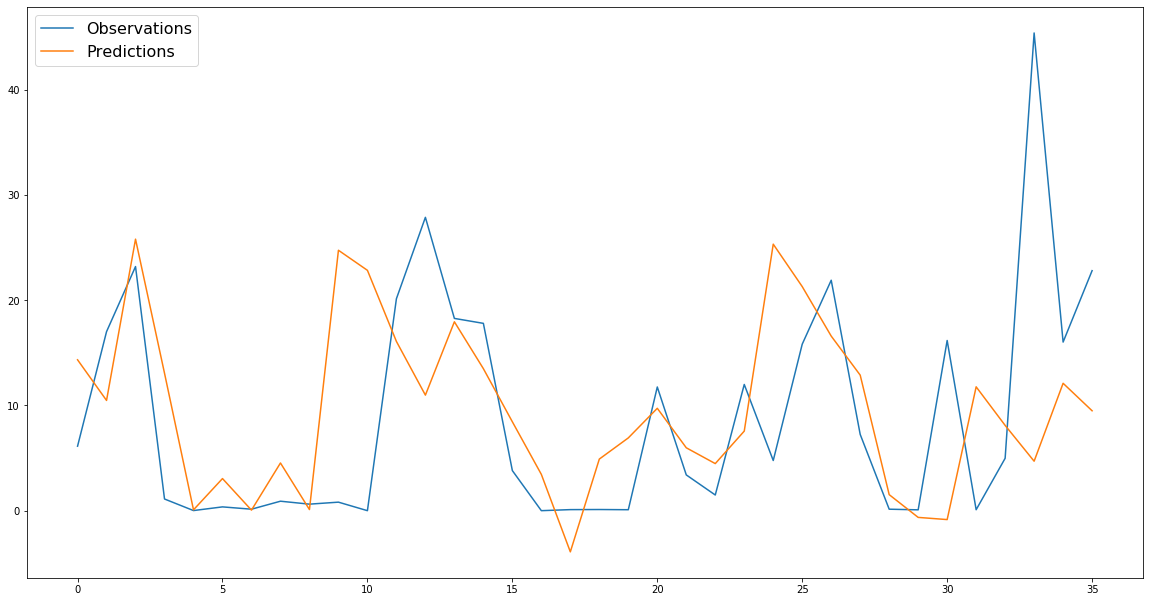

In [262]:
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend(fontsize = 16)

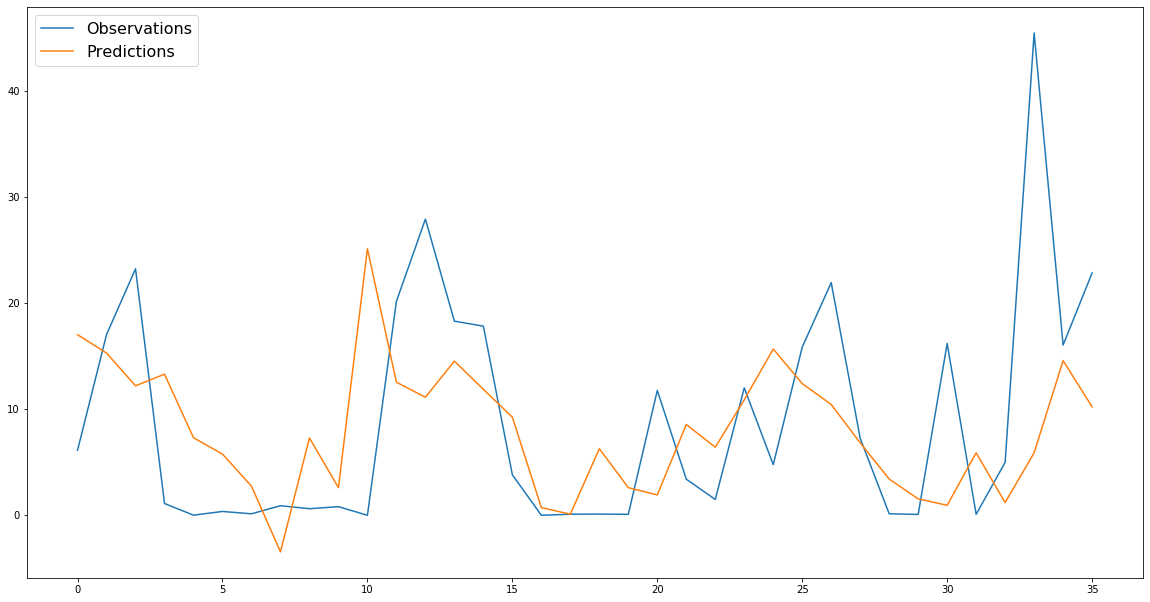

In [216]:
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend(fontsize = 16)

In [42]:
train_start

385

In [39]:
univariate_past_history = n*f
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(x, train_start, test_start,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(x, test_start, test_end,
                                       univariate_past_history,
                                       univariate_future_target)

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


In [28]:
def baseline(history):
    return np.mean(history)

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
x_train_uni

array([], dtype=float64)